## Light Curve Analysis 

WASP74b
- https://arxiv.org/pdf/1410.6358v2.pdf
- http://exoplanet.eu/catalog/wasp-74_b/

hanya linear

In [1]:
import math as mt
from numpy import *
import matplotlib.pyplot as plt

from os.path import join

from pytransit.orbits_f import orbits as of
from pytransit import MandelAgol as MA

from exotk.de import DiffEvol
from exotk.priors import PriorSet, UP, NP, JP
from exotk.utils.orbits import as_from_rhop
from exotk.utils.likelihood import ll_normal_es

from emcee import EnsembleSampler
from emcee import autocorr

%matplotlib inline

### Read the transit data

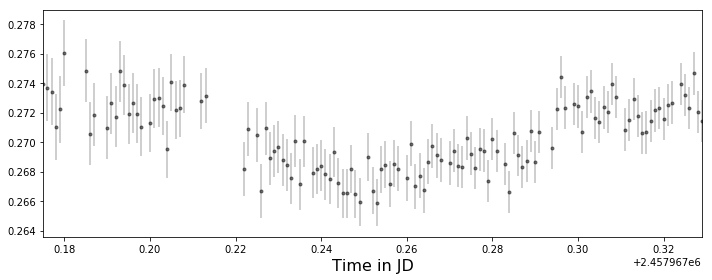

In [2]:
data = genfromtxt('wasp44_lc.dat', names=['jd', 'flux', 'errflux'])
fig, ax = plt.subplots(1,1, figsize=(10,4))
ax.errorbar(data['jd'], data['flux'], yerr=data['errflux'], fmt='k.', ecolor='grey', alpha=0.5)
ax.set_xlabel("Time in JD", fontsize=16)
ax.set_xlim([data['jd'].min(), data['jd'].max()])
plt.tight_layout()

### Simple normalization

In [3]:
t = data['jd'] 
flux = data['flux'] / 0.2725
errflux = data['errflux'] / 0.2725

In [4]:
print t.min(), t.max()

2457967.175 2457967.329


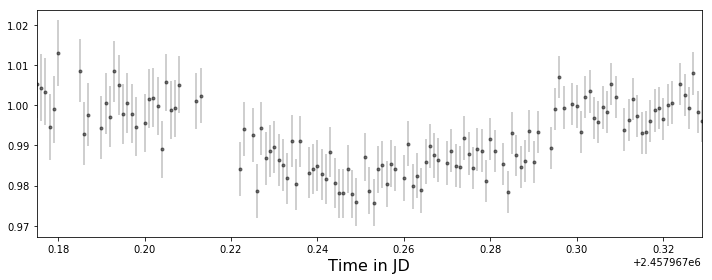

In [5]:
fig, ax = plt.subplots(1,1, figsize=(10,4))
ax.errorbar(t, flux, yerr=errflux, fmt='k.', ecolor='grey', alpha=0.5)
ax.set_xlabel("Time in JD", fontsize=16)
ax.set_xlim([t.min(), t.max()])
plt.tight_layout()

### Log Posterior Function

We want to include detrending process in this analysis.

Function that we want to fit:

$$F_{ratio+trend} = (F_{ratio}) + A + B(t-\bar{t}) $$ 

only linear trend

In [6]:
class LPFunction(object):
    """A simple log posterior function class.
    """
    def __init__(self, time, dm, nthreads=2):
        # time, magnitude
        self.tm = MA(lerp=True, klims=(0.08, 0.13), nthr=nthreads) 
        self.nthr = nthreads

        self.time     = time.copy()
        self.dm_o   = dm.copy()
        self.npt      = dm.size
        self.meant    = mean(self.time)
        self.timeshift = self.time - self.meant
#         self._wrk_lc  = zeros_like(time)  # These two work arrays are actually rather pointless
        self._wrk_ld  = zeros(2)          #
        
        self.priors = [NP(2457967.26, 0.02,  'tc'), ##  0  - Transit centre
                       NP(2.4238039,  0.02,   'p'),   ##  1  - Period
                       JP( 0.01,  0.02,  'k2'),  ##  2  - planet-star area ratio
                       NP(   1.69,    0.05, 'rho'),  ##  3  - Stellar density in gr/cm^3
                       UP(     0,   0.99,   'b'),   ##  4  - Impact parameter
                       UP( 0.002,   0.02,   'e'),   ##  5  - White noise std
                       UP(     0,    1.0,  'q1'),   ##  6  - limb darkening q1
                       UP(     0,    1.0,  'q2'),   ##  7  - limb darkening q2
                       UP(   -1.5,   1.5,   'A'),   ##  8  - constant
                       UP(   -2.0E-2,   2.0E-2,   'B')]#,   ##  9  - linear constant
                       #UP(   -5.0E-3,   5.0E-3,   'C')]   ##  10 - quadratic constant
        
        
        self.ps = PriorSet(self.priors)
        
#     def compute_baseline(self, pv):
#         """Simple constant baseline model"""
#         self._wrk_lc.fill(pv[6])
#         return self._wrk_lc

    
    def compute_transit(self, pv):
        """Transit model"""
        _a  = as_from_rhop(pv[3], pv[1])  # Scaled semi-major axis from stellar density and orbital period
        _i  = mt.acos(pv[4]/_a)           # Inclination from impact parameter and semi-major axis
        _k  = mt.sqrt(pv[2])              # Radius ratio from area ratio
        
        a, b = mt.sqrt(pv[6]), 2*pv[7]
        self._wrk_ld[:] = a*b, a*(1.-b)   # Quadratic limb darkening coefficients
        
        return self.tm.evaluate(self.time, _k, self._wrk_ld, pv[0], pv[1], _a, _i)

    
    def compute_lc_model(self, pv):
        """Combined baseline and transit model"""
        """in magnitude"""
        return pv[8] + self.compute_transit(pv) +  pv[9]*self.timeshift# + pv[10]*self.timeshift*self.timeshift


    def __call__(self, pv):
        """Log posterior density"""
        if any(pv < self.ps.pmins) or any(pv > self.ps.pmaxs):
            return -inf
        
        dm_m = self.compute_lc_model(pv)
        return self.ps.c_log_prior(pv) + ll_normal_es(self.dm_o, dm_m, pv[5])

### Basic parameter estimation

Generate parameter vector population clumped around the posterior maxima using Differential Evolution

In [7]:
npop, de_iter, mc_iter = 100, 100, 5000 # nwalkers, de_iteration_number, mcmc_iteration

lpf = LPFunction(t, flux)

de = DiffEvol(lpf, lpf.ps.bounds, npop, maximize=True)

In [8]:
npar = lpf.ps.ndim

In [9]:
de.optimize(de_iter)

(array([  2.45796726e+06,   2.42638578e+00,   1.48261156e-02,
          1.67888795e+00,   5.88413177e-01,   4.45708499e-03,
          6.13810498e-01,   7.07787410e-01,   2.80583617e-05,
         -7.29161657e-03]), -523.30001007263843)

In [10]:
print lpf.ps.bounds

[[  2.45796716e+06   2.45796736e+06]
 [  2.32380390e+00   2.52380390e+00]
 [  1.00000000e-02   2.00000000e-02]
 [  1.44000000e+00   1.94000000e+00]
 [  0.00000000e+00   9.90000000e-01]
 [  2.00000000e-03   2.00000000e-02]
 [  0.00000000e+00   1.00000000e+00]
 [  0.00000000e+00   1.00000000e+00]
 [ -1.50000000e+00   1.50000000e+00]
 [ -2.00000000e-02   2.00000000e-02]]


### Run MCMC

In [11]:
sampler = EnsembleSampler(npop, lpf.ps.ndim, lpf) # init sampler (nwalkers, ndim, lnprob posterior)

In [12]:
sampler.run_mcmc(de.population, mc_iter); # run mcmc (starting guess, number of step)

#### Overview

The MCMC chains are now stored in sampler.chain. Let's first have a look into how the chain populations evolved to see if we have any problems with our setup, whether we have converged to sample the true posterior distribution, and, if so, what was the burn-in time.

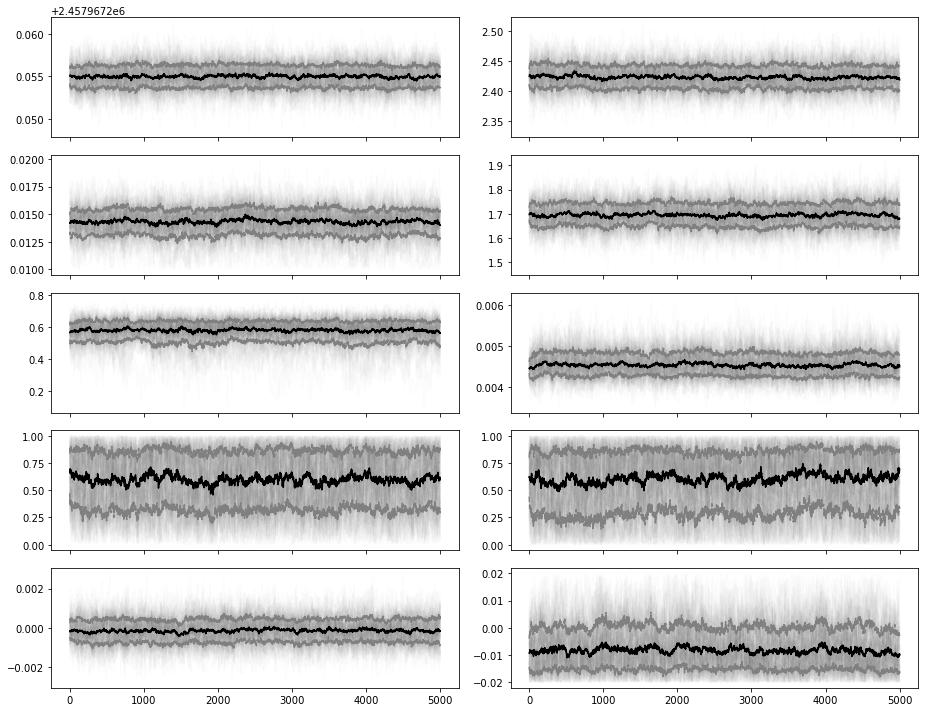

In [13]:
fig, axs = plt.subplots(5,2, figsize=(13,10), sharex=True)
ls, lc = ['-','--','--'], ['k', '0.5', '0.5']
percs = [percentile(sampler.chain[:,:,i], [50,16,84], 0) for i in range(npar)]
[axs.flat[i].plot(sampler.chain[:,:,i].T, 'k', alpha=0.01) for i in range(npar)]
[[axs.flat[i].plot(percs[i][j], c=lc[j], ls=ls[j]) for j in range(3)] for i in range(npar)]
fig.tight_layout()

Good, they don't show any significant long-term trends. We can decide a suitable *burning factor* (due to initial guess).

Look the mean autocorrelation length for each parameter in order to decide a suitable MCMC chain *thinning factor* (because the consecutive MCMC samples are correlated)

In [14]:
sampler.chain.shape
autocor = autocorr.integrated_time(sampler.chain.reshape((-1, lpf.ps.ndim)), c=10, axis=0)
print autocor
print 'mean = ', int(mean(autocor))

[ 170.21929501  157.12476992  236.00277292  144.40326552  216.80937769
  208.27292078  220.82138042  189.34066826  166.26071644  198.8612894 ]
mean =  190


#### Burn-it all baby

In [15]:
burn = int(mc_iter/10.)
thin = int(mean(autocor))
walkers = sampler.chain[:, burn::thin, :]
samples = walkers.reshape((-1, lpf.ps.ndim)) #nsamples, n_parameter

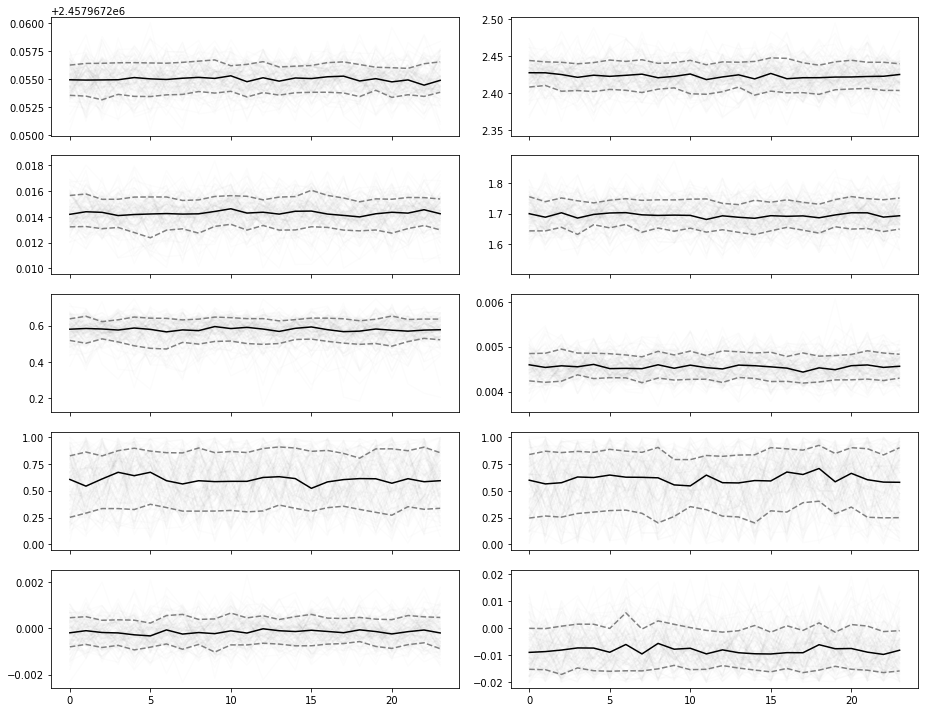

In [16]:
fig, axs = plt.subplots(5,2, figsize=(13,10), sharex=True)
ls, lc = ['-','--','--'], ['k', '0.5', '0.5']
percs = [percentile(walkers[:,:,i], [50,16,84], 0) for i in range(npar)]
[axs.flat[i].plot(walkers[:,:,i].T, 'k', alpha=0.01) for i in range(npar)]
[[axs.flat[i].plot(percs[i][j], c=lc[j], ls=ls[j]) for j in range(3)] for i in range(npar)]
#setp(axs, yticks=[])
fig.tight_layout()

### Analysis the Result

In [17]:
import corner

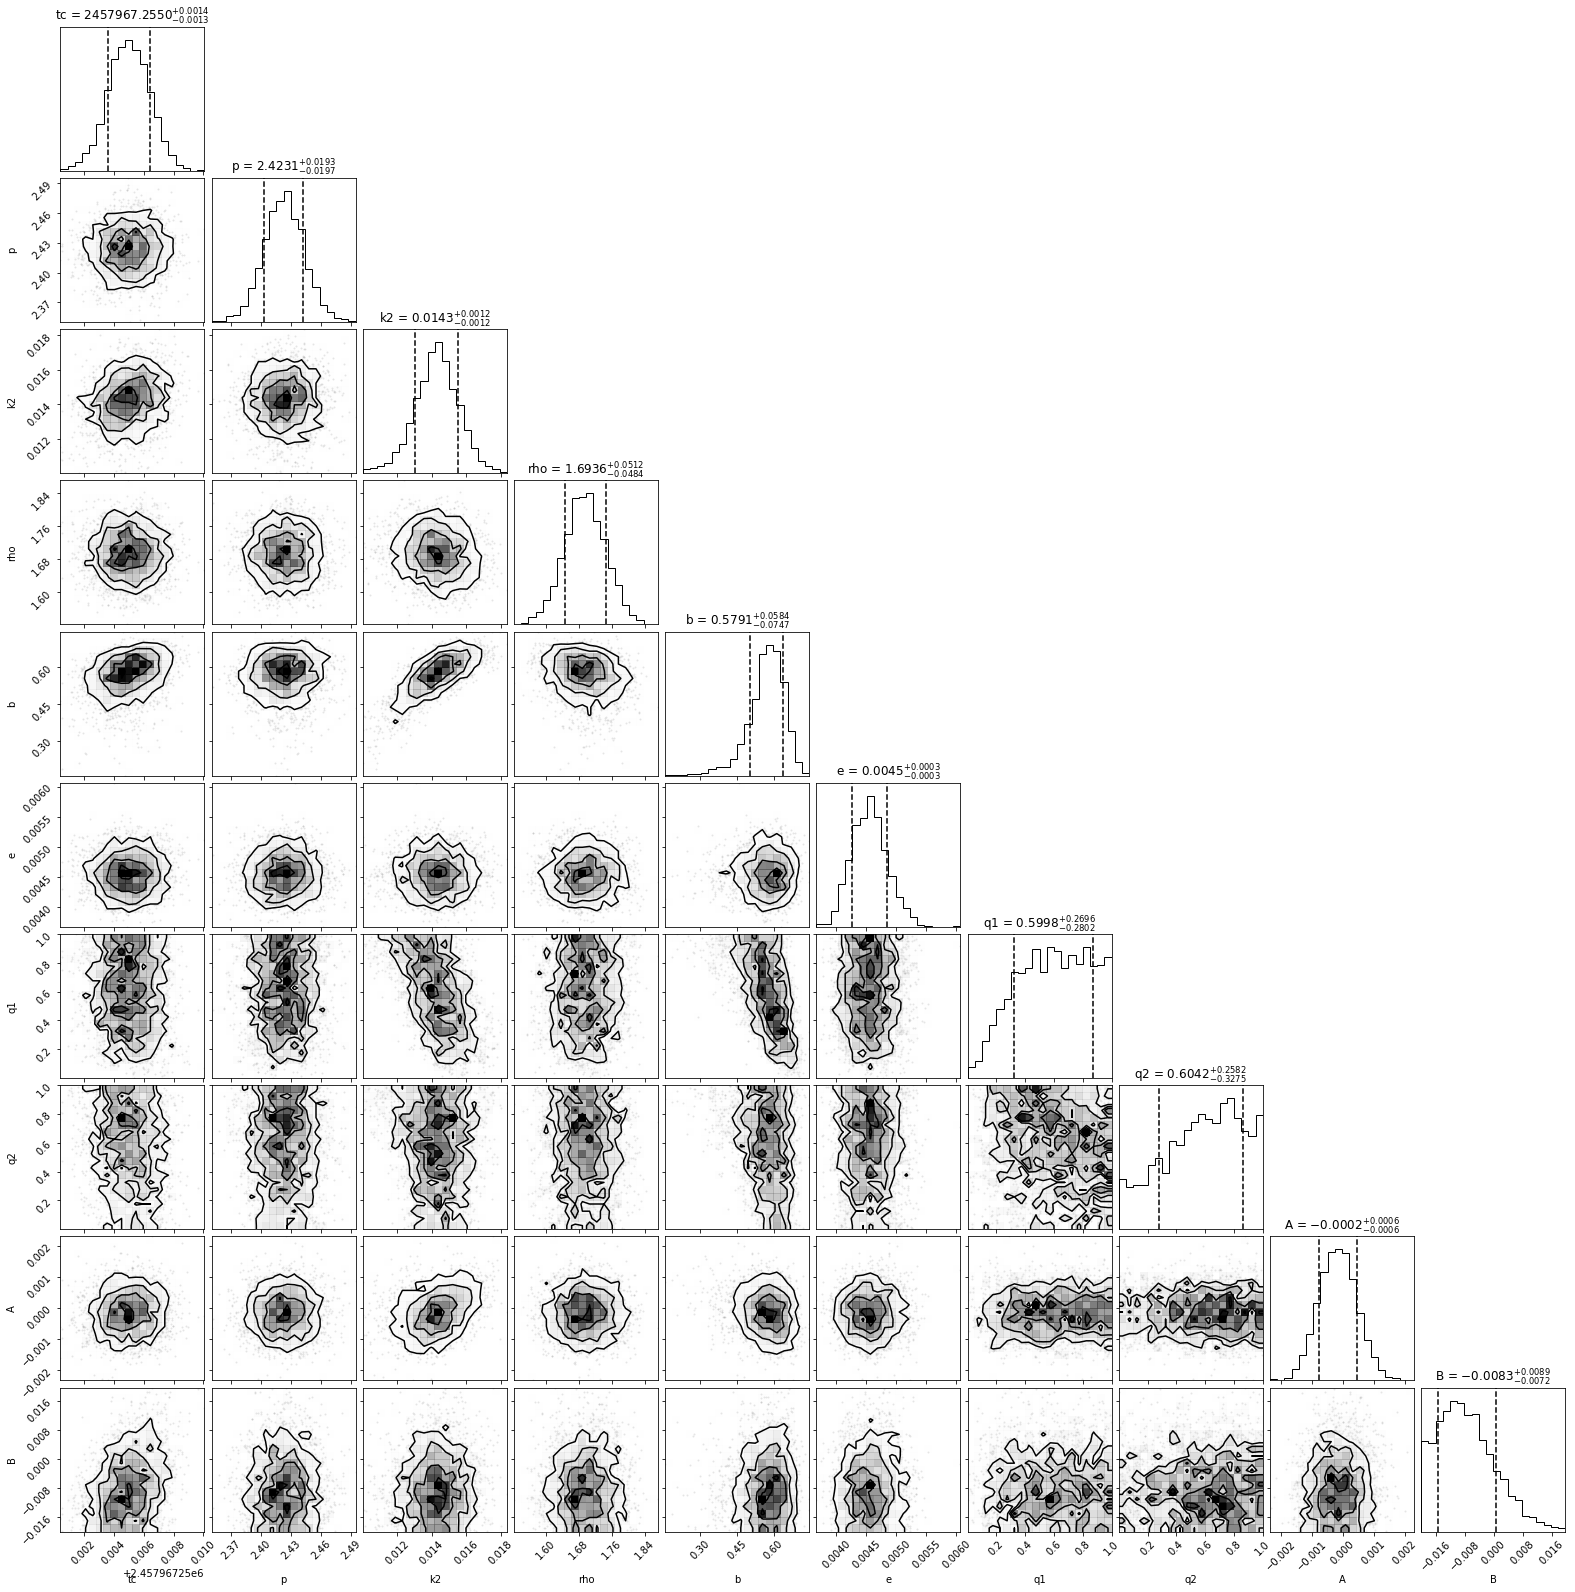

In [18]:
fig = corner.corner(samples, quantiles=(0.16, 0.84), show_titles=True, title_fmt='.4f', \
                    # truths=[params.t0, params.per, k2_true, density_true.value, b_true, std, 1.0, q1_true, q2_true], \
                    labels=lpf.ps.names, title_kwargs={"fontsize": 12})

#### Quantile of parameters, median $\pm '1 \sigma'$

In [19]:
pars = lpf.ps.names
theta = zeros(npar*3).reshape((npar,3)) 
for i in range(npar):
    theta[i,:] = corner.quantile(samples[:,i], [0.16, 0.5, 0.84]) # median = theta[:,1]
    print pars[i], "\t = ", theta[i,1], "\t +- ", [theta[i,2]-theta[i,1], theta[i,0]-theta[i,1]]

tc 	 =  2457967.25498 	 +-  [0.0014248662628233433, -0.0013476465828716755]
p 	 =  2.42310688375 	 +-  [0.019274782108936961, -0.019691625091310172]
k2 	 =  0.0142744077752 	 +-  [0.0012416755368017743, -0.0012465966487071167]
rho 	 =  1.6935790048 	 +-  [0.051230772636408961, -0.04836173692183543]
b 	 =  0.57911679229 	 +-  [0.058407025530225587, -0.074675399277408738]
e 	 =  0.00454664776675 	 +-  [0.00030128897573591159, -0.00029251886409256602]
q1 	 =  0.599757955815 	 +-  [0.26956866389694101, -0.28020633886447005]
q2 	 =  0.604209335468 	 +-  [0.25822782994432858, -0.32752927429762474]
A 	 =  -0.00016585565722 	 +-  [0.00062332791606822834, -0.00059906666307491007]
B 	 =  -0.00827409701405 	 +-  [0.0089321487376193796, -0.0071989821808380074]


In [20]:
# radius ratio
radius_ratio = sqrt(samples[:,2])
kk = corner.quantile(radius_ratio, [0.16, 0.5, 0.84])
print "radius ratio = ", kk[1], "+-", [kk[2]-kk[1], kk[0]-kk[1]]

# scaled semimajor axis
_a = as_from_rhop(samples[:,3], samples[:,1])
kk = corner.quantile(_a, [0.16, 0.5, 0.84])
print "scaled semimajor axis = ", kk[1], "+-", [kk[2]-kk[1], kk[0]-kk[1]]

# inclination
TORAD = 180./pi
inc = arccos(samples[:,4]/_a) * TORAD
ii = corner.quantile(inc, [0.16, 0.5, 0.84])
print "inclination = ", ii[1], "+-", [ii[2]-ii[1], ii[0]-ii[1]]

# limb darkening coeffs
u = 2*sqrt(samples[:,6])*samples[:,7]
v = sqrt(samples[:,6])*(1. - 2*samples[:,7])
uu = corner.quantile(u, [0.16, 0.5, 0.84])
vv = corner.quantile(v, [0.16, 0.5, 0.84])
print "u = ", uu[1], "+-", [uu[2]-uu[1], uu[0]-uu[1]]
print "v = ", vv[1], "+-", [vv[2]-vv[1], vv[0]-vv[1]]

radius ratio =  0.119475552697 +- [0.0050880181942704189, -0.0053361158057832619]
scaled semimajor axis =  8.06771978669 +- [0.093231958104260215, -0.084465146692637383]
inclination =  85.8870027889 +- [0.5377763991678961, -0.43494727675303579]
u =  0.858785204037 +- [0.4309376053054309, -0.46553766060153245]
v =  -0.153543870729 +- [0.49329553480521199, -0.35505431897016204]


In [21]:
mp = theta[:,1] # median of parameters

In [22]:
print mp

[  2.45796725e+06   2.42310688e+00   1.42744078e-02   1.69357900e+00
   5.79116792e-01   4.54664777e-03   5.99757956e-01   6.04209335e-01
  -1.65855657e-04  -8.27409701e-03]


In [23]:
# compute the light curve using first 1000 derived parameters
flux_pr = array([lpf.compute_lc_model(pv) for pv in samples[random.permutation(samples.shape[0])[:1000]]]) 

# flux percentile
flux_pc = array(percentile(flux_pr, [50, 0.15, 99.85, 2.5, 97.5, 16, 84], 0))

### Overplot the result with data

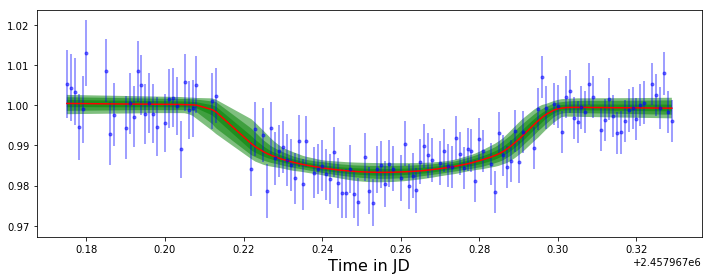

In [24]:
zx1,zx2,zy1,zy2 = 0.95, 0.965, 0.985, 0.99
fig, ax = plt.subplots(1,1, figsize=(10,4))

# data with errorbar from calculation
ax.errorbar(lpf.time, lpf.dm_o, errflux, fmt='.', c='b', alpha=0.5) 

# combination from other percentile
[ax.fill_between(lpf.time,*flux_pc[i:i+2,:], alpha=0.5, facecolor='g') for i in range(1,6,2)] 

# median (center line)
ax.plot(lpf.time, flux_pc[0], c='r') 

#setp(ax, xlim=lpf.time[[0,-1]], xlabel='Time', ylabel='Normalized flux')

ax.set_xlabel("Time in JD", fontsize=16)
#ax.set_ylabel(r"Delta magnitude ($\Delta m$)", fontsize=16)
#ax.set_xlim([2457597.0, 2457597.28])
#ax.set_ylim([-1.045, -1.010])

#ax.invert_yaxis()
fig.tight_layout()

### Removed trend

<Container object of 3 artists>

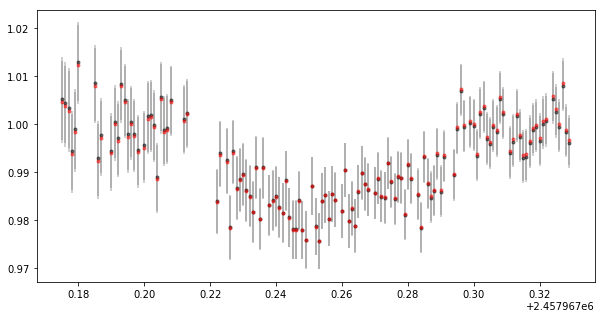

In [25]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.errorbar(lpf.time, lpf.dm_o, yerr=errflux, fmt='k.', ecolor='grey', alpha=0.5)
ax.errorbar(lpf.time, lpf.dm_o - mp[9]*lpf.timeshift, yerr=errflux, fmt='r.', ecolor='grey', alpha=0.5)
#ax.invert_yaxis()

### Check correlation plot of some parameters

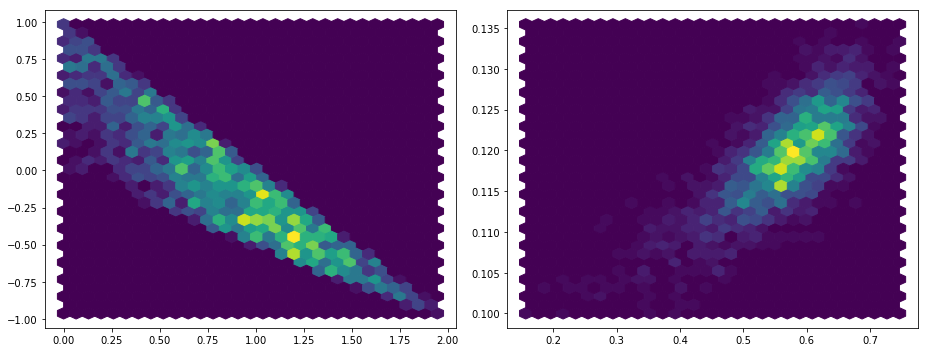

In [26]:
fig, axs = plt.subplots(1,2, figsize=(13,5))
cpars = dict(gridsize=30)
axs[0].hexbin(u,v, **cpars)
axs[1].hexbin(samples[:,4],radius_ratio, **cpars)
fig.tight_layout()

Calculate R planet using mass of the star

In [27]:
Mstar = 0.951
sigmaMstar = 0.034

In [28]:
N = len(samples[:,2])
print N

2400


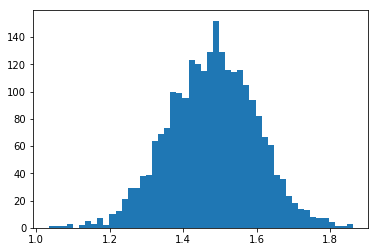

In [29]:
Ms = random.normal(Mstar, sigmaMstar, N)
plt.hist(Ms, bins=50);

In [30]:
Vol = Ms*2e30/(samples[:,3]*1000) # M/rho

In [31]:
rstar = (3.*Vol/(4*pi))**(1/3.)

In [32]:
rp_km = sqrt(samples[:,2])*rstar/1000

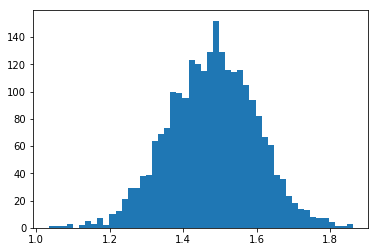

In [33]:
rp_jupiter = rp_km/69911.
plt.hist(Ms, bins=50);

In [34]:
rpj = corner.quantile(rp_jupiter, [0.16, 0.5, 0.84])
print "radius of planet in jup radius", rpj[1], "+-", [rpj[2]-rpj[1], rpj[0]-rpj[1]]

radius of planet in jup radius 1.27510532004 +- [0.065779982093866929, -0.069994694277179637]
